In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import morphology
import os
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from dipy.align import (affine_registration, center_of_mass, translation,
                        rigid, affine)
from dipy.align.imaffine import AffineMap
from dipy.align.transforms import AffineTransform3D
from dipy.align.imaffine import AffineRegistration # as affreg
import pandas as pd

In [3]:
current_directory = os.environ['HOME']
#JAS:
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/DUPONT/datasplit/FixedPath/test_data.csv')

#JAG:
#test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/General_dataset/datasplit/FixedPath/test_data.csv')

df_test = pd.read_csv(test_data_path)

data = []
#for i in range(0, len(df_test)):
for i in range(0, 1):
    data.append([os.path.join(current_directory, df_test["DWI_path"][i]),
                os.path.join(current_directory, df_test["ADC_path"][i]),
                os.path.join(current_directory, df_test["b0"][i]),
                os.path.join(current_directory, df_test["Label_path"][i])])
    
#Check number of scans in datasplit:
for idx in range(0,len(data)):
    print('Subject:',idx+1)
    #Load data:
    DWI_path, ADC_path, b0_path, label_path = data[idx]

    DWI_vol = nib.load(DWI_path).get_fdata()
    ADC_vol = nib.load(ADC_path).get_fdata()
    b0_vol = nib.load(b0_path).get_fdata()
    label_vol = nib.load(label_path).get_fdata()

Subject: 1


22


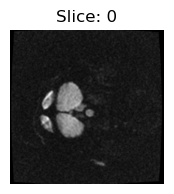

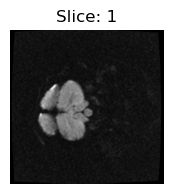

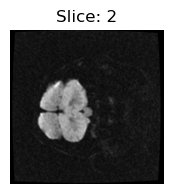

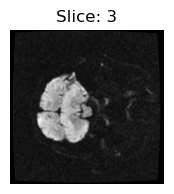

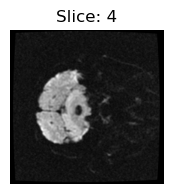

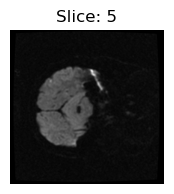

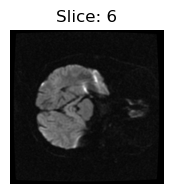

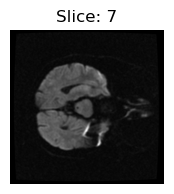

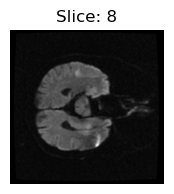

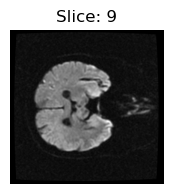

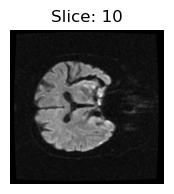

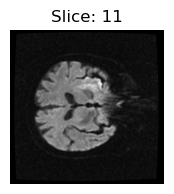

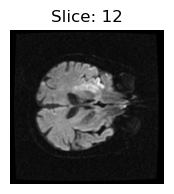

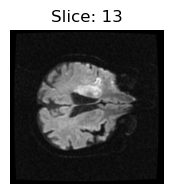

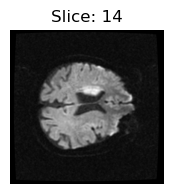

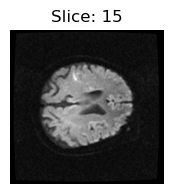

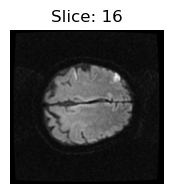

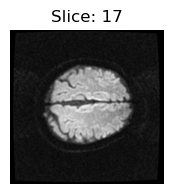

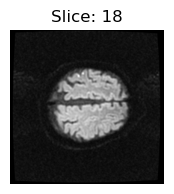

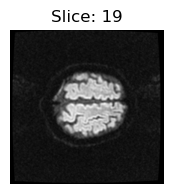

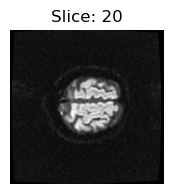

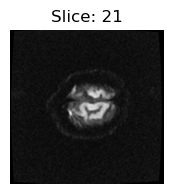

In [13]:
DWI_path, ADC_path, b0_path, label_path = data[0]
DWI_vol = nib.load(DWI_path).get_fdata()
print(len(DWI_vol[0,0,:]))
for slice_idx in range(0,len(DWI_vol[0,0,:])):
    DWI_slice = DWI_vol[:,:,slice_idx]

    fig, axes = plt.subplots(1, 1, figsize=(2,2))
    axes.imshow(DWI_slice, cmap='gray')
    axes.set_title('Slice: ' + str(slice_idx))
    axes.axes.axis('off')
    plt.show()

# h og v forskel

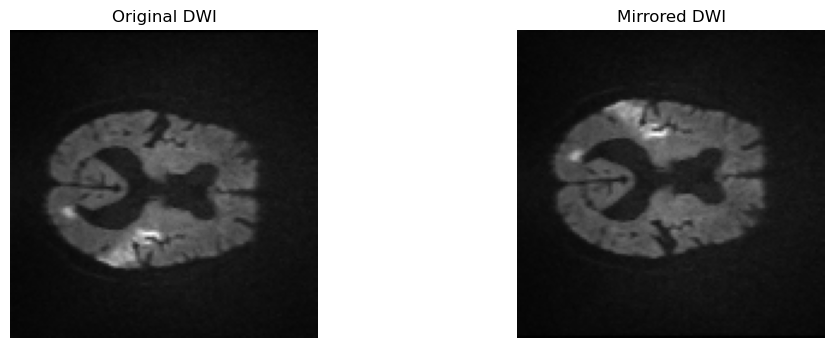

In [160]:
# Mirror the DWI volume horizontally
DWI_vol_mir = np.flipud(DWI_vol)
DWI_slice_mir = DWI_vol_mir[:,:,slice_idx]

# Display the original and mirrored images side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(DWI_slice, cmap='gray')
axes[0].set_title('Original DWI')
axes[1].imshow(DWI_slice_mir, cmap='gray')
axes[1].set_title('Mirrored DWI')
for ax in axes:
    ax.axis('off')
plt.show()

In [161]:
# Register mirrored DWI to DWI
affreg = AffineRegistration(level_iters=[0])
affine3d = affreg.optimize(DWI_vol, DWI_vol_mir, AffineTransform3D(), params0=None)

Optimizing level 0 [max iter: 0]


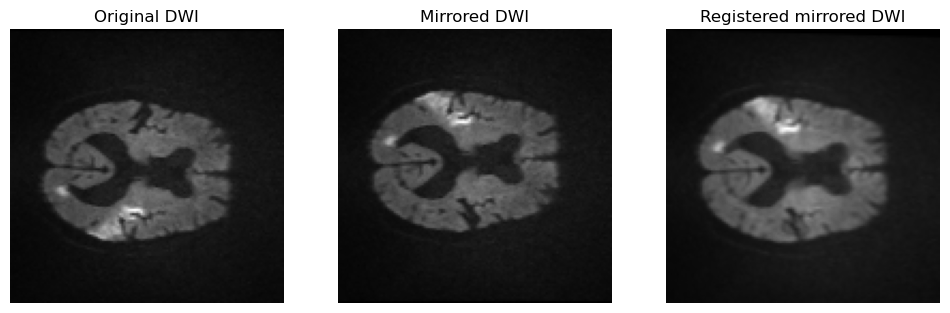

In [162]:
# Overlay
DWI_vol_reg = affine3d.transform(DWI_vol_mir)
DWI_slice_reg = DWI_vol_reg[:,:,slice_idx]

# Display the original and mirrored images side by side using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(DWI_slice, cmap='gray')
axes[0].set_title('Original DWI')
axes[1].imshow(DWI_slice_mir, cmap='gray')
axes[1].set_title('Mirrored DWI')
axes[2].imshow(DWI_slice_reg, cmap='gray')
axes[2].set_title('Registered mirrored DWI')
for ax in axes:
    ax.axis('off')
plt.show()

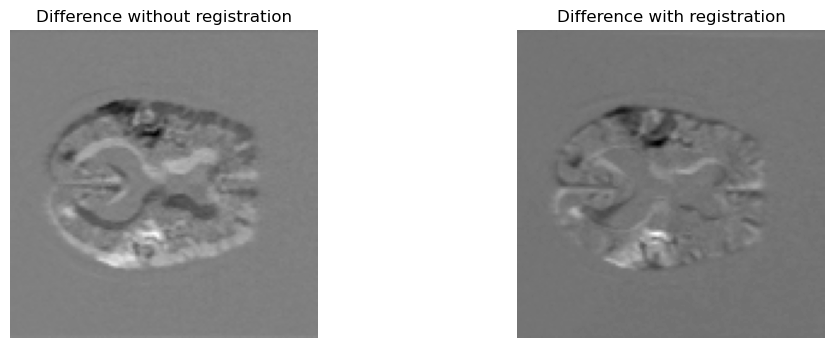

In [163]:
#Difference between mirrored DWI with and without registration
dif_slice1 = DWI_slice - DWI_slice_mir
dif_slice2 = DWI_slice - DWI_slice_reg

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(dif_slice1 , cmap='gray')
axes[0].set_title('Difference without registration')
axes[1].imshow(dif_slice2, cmap='gray')
axes[1].set_title('Difference with registration')
for ax in axes:
    ax.axis('off')
plt.show()

# Forskel på ADC og b0

(-0.5, 127.5, 127.5, -0.5)

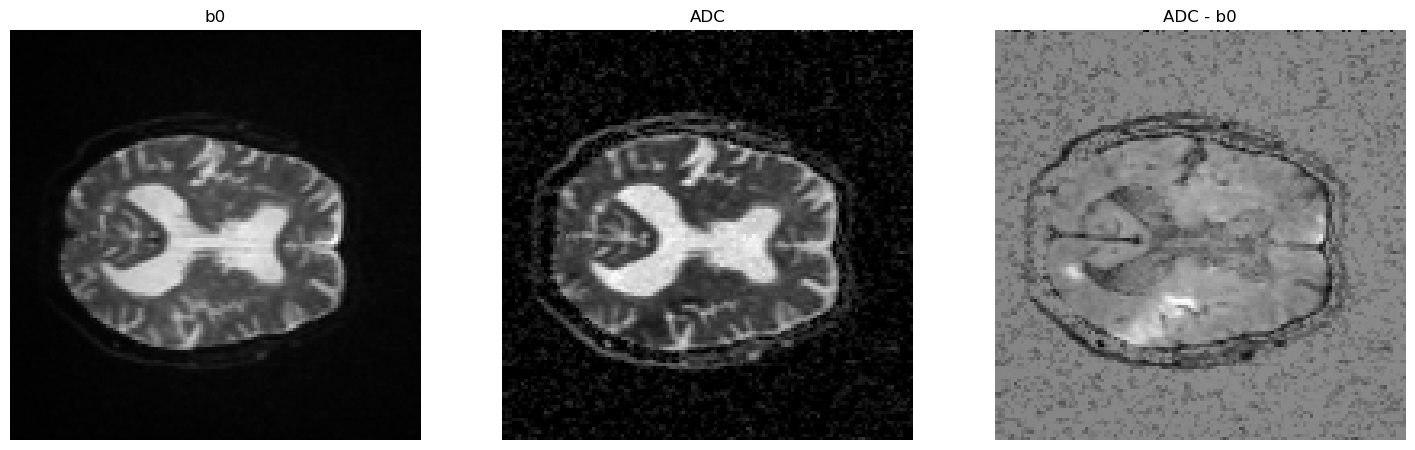

In [164]:
# Forskel på ADC og b0
ADC_slice_norm = (ADC_slice - np.min(ADC_slice)) / (np.max(ADC_slice) - np.min(ADC_slice))
b0_slice_norm = (b0_slice - np.min(b0_slice)) / (np.max(b0_slice) - np.min(b0_slice))

modality_dif = b0_slice_norm - ADC_slice_norm

fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # Adjust figsize as needed
axes[0].imshow(b0_slice, cmap='gray')  # Assuming grayscale images
axes[0].set_title('b0')
axes[0].axes.axis('off')
axes[1].imshow(ADC_slice, cmap='gray')  # Assuming grayscale images
axes[1].set_title('ADC')
axes[1].axes.axis('off')
axes[2].imshow(modality_dif, cmap='gray')  # Assuming grayscale images
axes[2].set_title('ADC - b0')
axes[2].axes.axis('off')

# Dif_dif


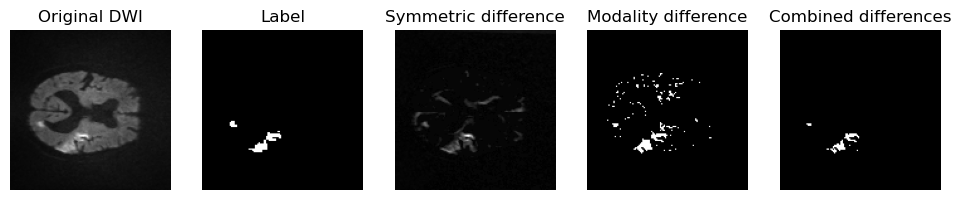

In [255]:
g1 = 1.25

b0_temp = b0_slice > b0_slice.mean()#*g1
ADC_temp = ADC_slice < ADC_slice.mean()*g1

#dif = ADC_temp ^ b0_temp #XOR: 1 if different and 0 if same
dif = ADC_temp & b0_temp #And: 1 if same


_DWI_slice = (DWI_slice- np.min(DWI_slice)) / (np.max(DWI_slice) - np.min(DWI_slice))
_DWI_slice_reg = (DWI_slice_reg - np.min(DWI_slice_reg)) / (np.max(DWI_slice_reg) - np.min(DWI_slice_reg))

symDif = _DWI_slice - _DWI_slice_reg
symDif = np.where((symDif > np.mean(symDif)), symDif, 0)

# Binary:
#_symDif = np.where((symDif > np.mean(symDif)), 1, 0)
_symDif = symDif > np.mean(_DWI_slice_reg) 

# Dif dif:
difDif = _symDif & dif #And: 1 if same

fig, axes = plt.subplots(1, 5, figsize=(12, 4))
axes[0].imshow(DWI_slice, cmap='gray')
axes[0].set_title('Original DWI')
axes[1].imshow(label_slice, cmap='gray')
axes[1].set_title('Label')
axes[2].imshow(symDif, cmap='gray')
axes[2].set_title('Symmetric difference')
axes[3].imshow(dif, cmap='gray')
axes[3].set_title('Modality difference')
axes[4].imshow(difDif, cmap='gray')
axes[4].set_title('Combined differences')
for ax in axes:
    ax.axis('off')
plt.show()

# Test on other slices:

In [302]:
#JAG:
test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/General_dataset/datasplit/FixedPath/test_data.csv')

#JAS:
#test_data_path = os.path.join(current_directory, 'mri-infarct-segmentation/data/DUPONT/datasplit/FixedPath/test_data.csv')
df_test = pd.read_csv(test_data_path)

data = []
for i in range(0, len(df_test)):
    data.append([os.path.join(current_directory, df_test["DWI_path"][i]),
                os.path.join(current_directory, df_test["ADC_path"][i]),
                os.path.join(current_directory, df_test["b0"][i]),
                os.path.join(current_directory, df_test["Label_path"][i])])

In [303]:
scan_idx = 2
slice_idx = 13

DWI_path, ADC_path, b0_path, label_path = data[scan_idx]
DWI_vol = nib.load(DWI_path).get_fdata()
ADC_vol = nib.load(ADC_path).get_fdata()
b0_vol = nib.load(b0_path).get_fdata()
label_vol = nib.load(label_path).get_fdata()
DWI_slice = DWI_vol[:,:,slice_idx]
ADC_slice = ADC_vol[:,:,slice_idx]
b0_slice = b0_vol[:,:,slice_idx]
label_slice = label_vol[:,:,slice_idx]

# Mirror the DWI volume horizontally
DWI_vol_mir = np.flipud(DWI_vol)

# Register mirrored DWI to DWI
affreg = AffineRegistration(level_iters=[0])
affine3d = affreg.optimize(DWI_vol, DWI_vol_mir, AffineTransform3D(), params0=None)

# Overlay
DWI_vol_reg = affine3d.transform(DWI_vol_mir)
DWI_slice_reg = DWI_vol_reg[:,:,slice_idx]

Optimizing level 0 [max iter: 0]


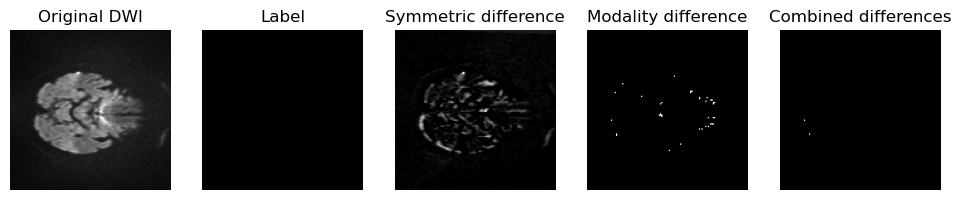

In [304]:
def DifDif_segmentation(g1):
    b0_temp = b0_slice > b0_slice.mean()#*g1
    ADC_temp = ADC_slice < ADC_slice.mean()*g1

    #dif = ADC_temp ^ b0_temp #XOR: 1 if different and 0 if same
    dif = ADC_temp & b0_temp #And: 1 if same


    _DWI_slice = (DWI_slice- np.min(DWI_slice)) / (np.max(DWI_slice) - np.min(DWI_slice))
    _DWI_slice_reg = (DWI_slice_reg - np.min(DWI_slice_reg)) / (np.max(DWI_slice_reg) - np.min(DWI_slice_reg))

    symDif = _DWI_slice - _DWI_slice_reg
    symDif = np.where((symDif > np.mean(symDif)), symDif, 0)

    # Binary:
    #_symDif = np.where((symDif > np.mean(symDif)), 1, 0)
    _symDif = symDif > np.mean(_DWI_slice_reg) 

    # Dif dif:
    difDif = _symDif & dif #And: 1 if same

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    axes[0].imshow(DWI_slice, cmap='gray')
    axes[0].set_title('Original DWI')
    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title('Label')
    axes[2].imshow(symDif, cmap='gray')
    axes[2].set_title('Symmetric difference')
    axes[3].imshow(dif, cmap='gray')
    axes[3].set_title('Modality difference')
    axes[4].imshow(difDif, cmap='gray')
    axes[4].set_title('Combined differences')
    for ax in axes:
        ax.axis('off')
    plt.show()

g1 = 1.2
DifDif_segmentation(g1)

Dice: 0.299


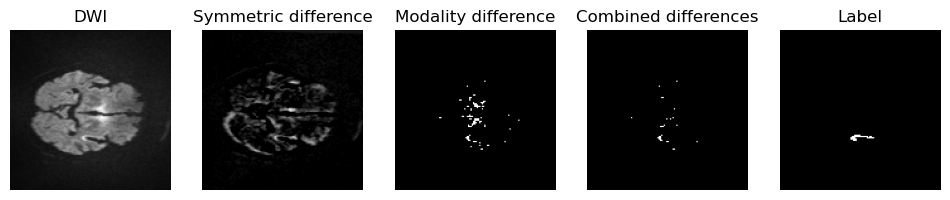

Dice: 0.419


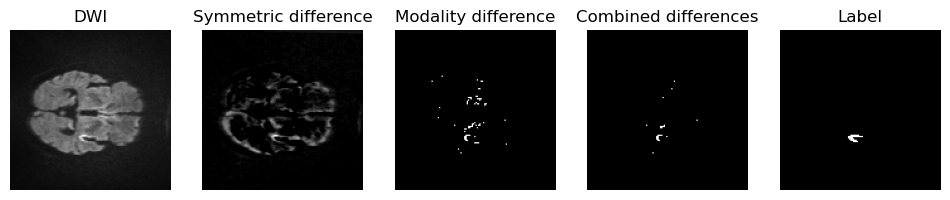

Dice: 0.485


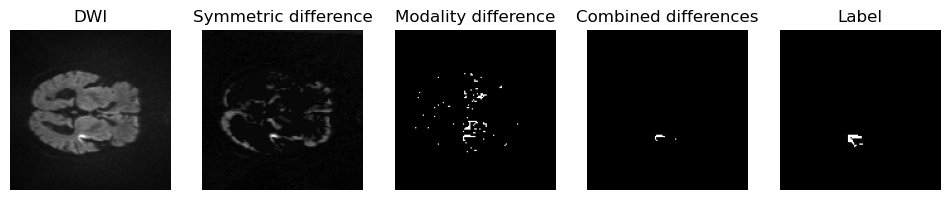

Dice: 0.727


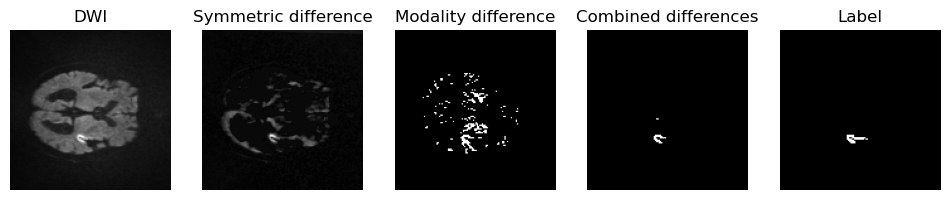

Dice: 0.73


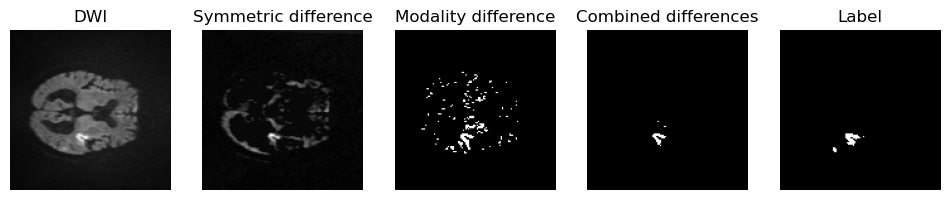

Dice: 0.494


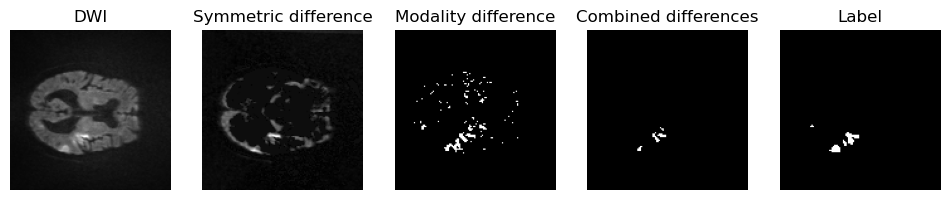

Dice: 0.485


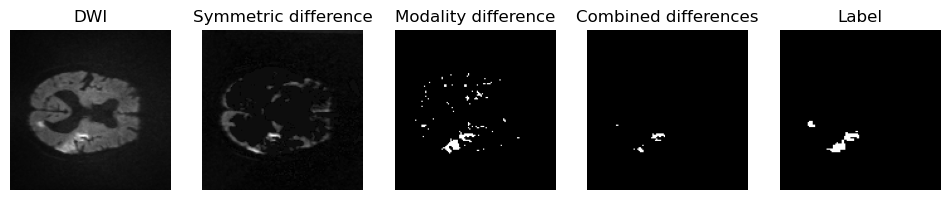

Dice: 0.59


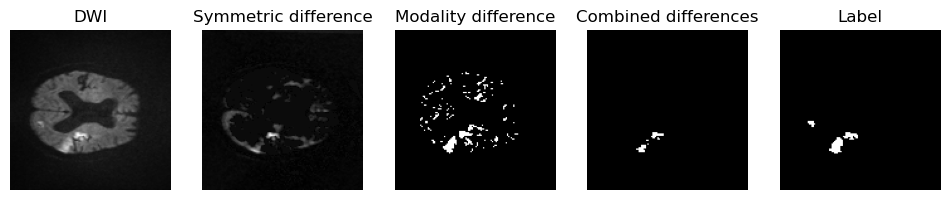

Dice: 0.636


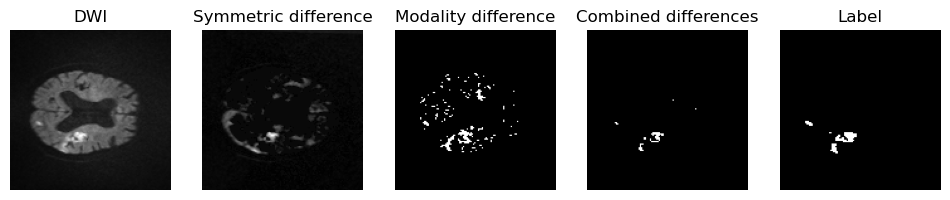

Dice: 0.488


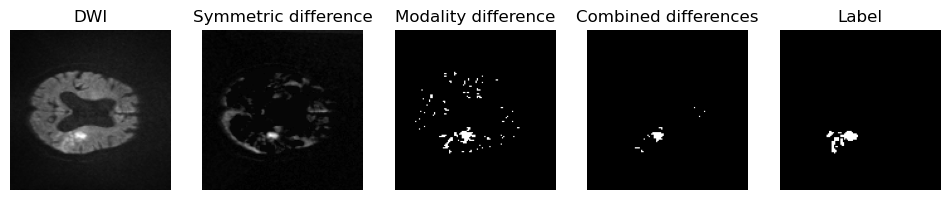

Dice: 0.417


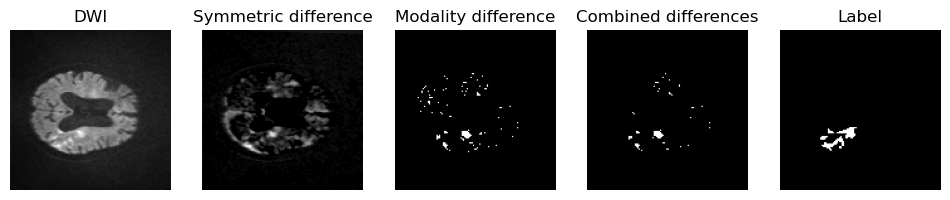

Dice: 0.403


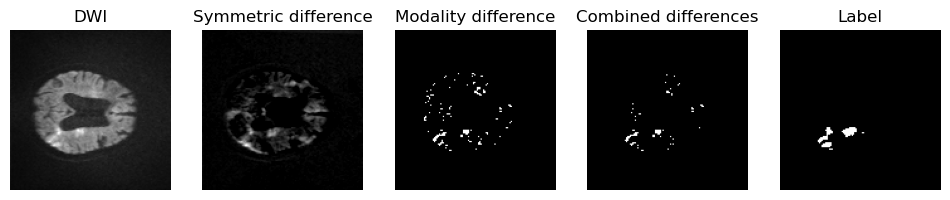

Dice: 0.45


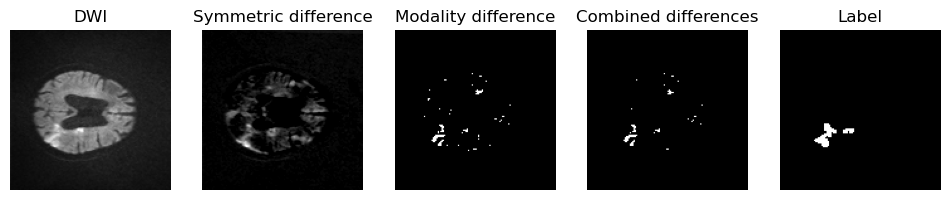

Dice: 0.372


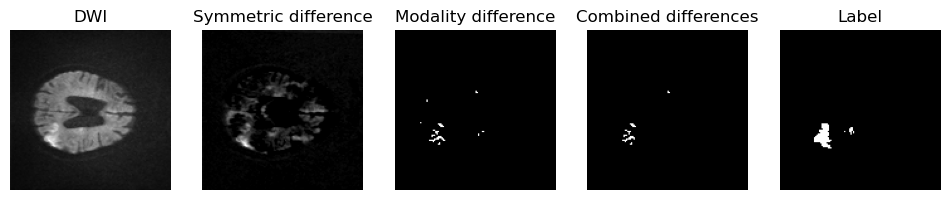

Dice: 0.292


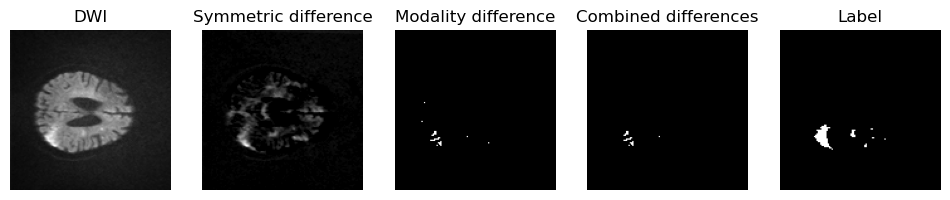

Dice: 0.167


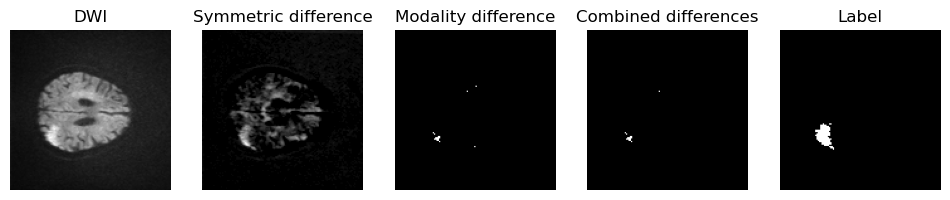

Dice: 0.04


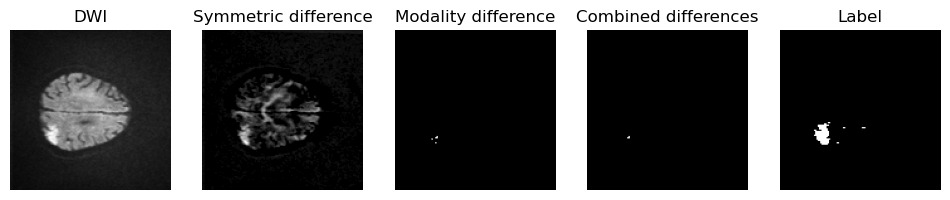

Dice: 0.02


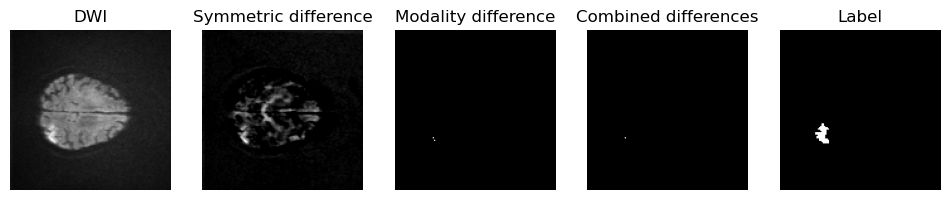

Dice: 0.0


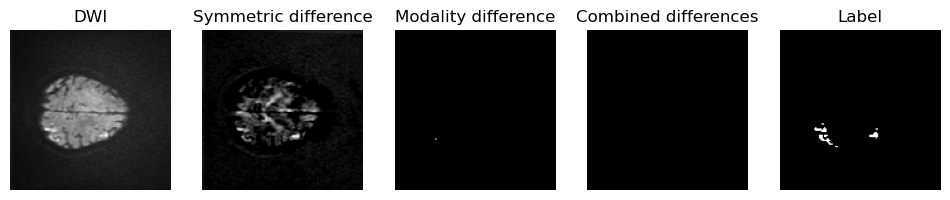

Dice: 0.0


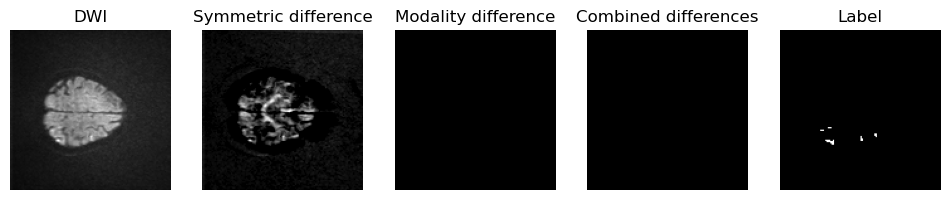

Dice: 0.0


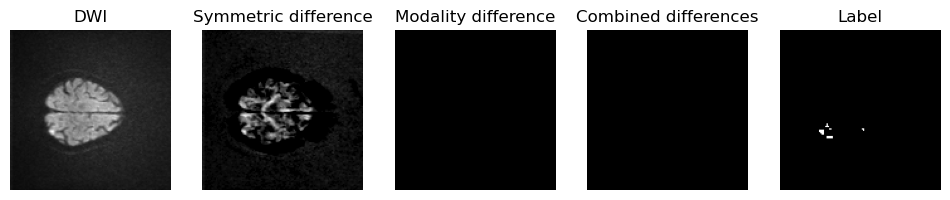

Dice: 0.0


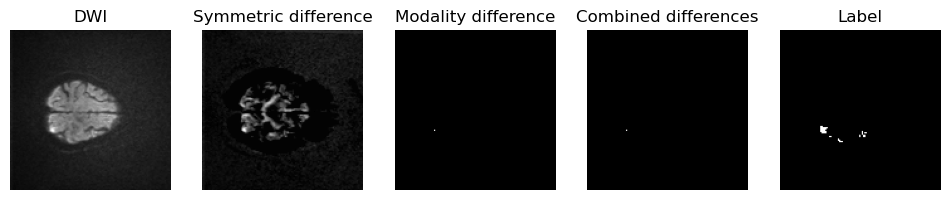

Dice: 0.0


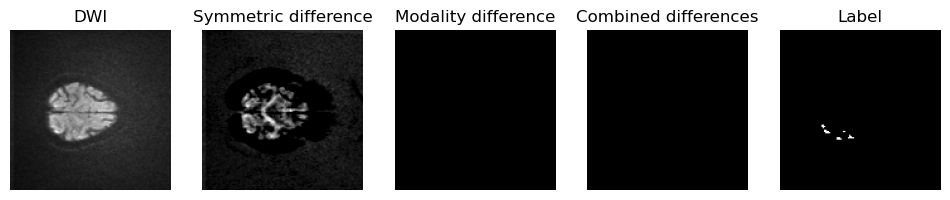

In [313]:
def DifDif_segmentation(g1):
    b0_temp = b0_slice > b0_slice.mean()#*g1
    ADC_temp = ADC_slice < ADC_slice.mean()*g1

    #dif = ADC_temp ^ b0_temp #XOR: 1 if different and 0 if same
    dif = ADC_temp & b0_temp #And: 1 if same


    _DWI_slice = (DWI_slice- np.min(DWI_slice)) / (np.max(DWI_slice) - np.min(DWI_slice))
    _DWI_slice_reg = (DWI_slice_reg - np.min(DWI_slice_reg)) / (np.max(DWI_slice_reg) - np.min(DWI_slice_reg))

    symDif = _DWI_slice - _DWI_slice_reg
    symDif = np.where((symDif > np.mean(symDif)), symDif, 0)

    # Binary:
    #_symDif = np.where((symDif > np.mean(symDif)), 1, 0)
    _symDif = symDif > np.mean(_DWI_slice_reg) 

    # Dif dif:
    difDif = _symDif & dif #And: 1 if same

    #
    _ADC_slice = (ADC_slice - np.min(ADC_slice)) / (np.max(ADC_slice) - np.min(ADC_slice))
    TH = np.where((_DWI_slice > 0.5) & (_ADC_slice < 0.5), 1, 0)
    difDif = difDif & TH

    #Dice:
    areaOfOverlap = np.sum(difDif * label_slice)
    totalArea = np.sum(difDif).item() + np.sum(label_slice)
    dice = (2*areaOfOverlap)/totalArea
    print('Dice:',round(dice,3))

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    axes[0].imshow(DWI_slice, cmap='gray')
    axes[0].set_title('DWI')
    axes[1].imshow(symDif, cmap='gray')
    axes[1].set_title('Symmetric difference')
    axes[2].imshow(dif, cmap='gray')
    axes[2].set_title('Modality difference')
    axes[3].imshow(difDif, cmap='gray')
    axes[3].set_title('Combined differences')
    axes[4].imshow(label_slice, cmap='gray')
    axes[4].set_title('Label')
    for ax in axes:
        ax.axis('off')
    plt.show()

for slice_idx in range(0,len(DWI_vol[0,0,:])):
    if np.sum(label_vol[:,:,slice_idx])> 0:
        DWI_slice = DWI_vol[:,:,slice_idx]
        ADC_slice = ADC_vol[:,:,slice_idx]
        b0_slice = b0_vol[:,:,slice_idx]
        label_slice = label_vol[:,:,slice_idx]

        DifDif_segmentation(1.2)